# Image Processor
The goal of this notebook is to create a model that can classify images of the following two classes:
- Kaninchen
- Feldhase

The comments in this notebook are plenty and generated mostly using the help of artificial intelligence. This approach is chosen, as it enables both the developers and the users of this notebook to understand the code better.

# Imports

In [203]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Adjust the GPU memory growth dynamically

In [204]:
gpus = tf.config.experimental.list_physical_devices('GPU') # Get the list of GPUs
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True) # enable tensorflow to allocate memory dynamically -> use only as much GPU memory as needed
gpus

[]

In [205]:
tf.config.list_physical_devices('GPU') # Check if GPU is available

[]

# Load images, multiplay them by applying data augmentation, and transform them into a numpy array

In [212]:
from keras.src.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance with various data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Scale the images to values between 0 and 1
    rotation_range=10,      # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1, # Randomly shift images vertically by up to 10%
    shear_range=0.2,        # Shear transformation to tilt the image by up to 20%
    zoom_range=0.2,         # Randomly zoom in on images by up to 20%
    # horizontal_flip=True,   # Randomly flip images horizontally, does not make sense in or case
    vertical_flip=False,    # No vertical flipping in this example
    fill_mode='nearest'     # Fill in missing pixels with the nearest available pixel
)

test_datagen = ImageDataGenerator(
    rescale=1./255         # Scale the images to values between 0 and 1
)

# Load data and apply transformations
train_set = train_datagen.flow_from_directory(
    'photos',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

validation_set = test_datagen.flow_from_directory(
    'photos',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

test_set = test_datagen.flow_from_directory(
    'photos',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# Create the model

In [207]:
# sequential means that the layers are stacked on top of each other leading to a feed forward neural network
model = tf.keras.models.Sequential([
    # Adding a convolutional layer to detect features in the images
    
    # 16 filters to detect 16 different features like edges, textures, structure etc.
    # 3x3 kernel size to detect features in a 3x3 area
    # 1 stride to move the kernel by 1 pixel
    # relu activation function to introduce non-linearity
    # input shape: height, width, colors/channels (RGB)
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)), # output shape: 254x254x16 (width, height, features)

    # Adding a max pooling layer to reduce the dimensionality of the data
    # achieved by taking the maximum value of a 2x2 area as the representative value for that area
    tf.keras.layers.MaxPool2D(), # output shape: 127x127x16
    
    # Adding more layers to continously learn more complex features
    # Continouse learning of more complex features is achieved by increasing the number of filters
    # A more compact representation of the data is achieved by reducing the kernel size continuously via max pooling
    tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'), # output shape: 125x125x32
    tf.keras.layers.MaxPool2D(), # output shape: 62x62x32
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'), # output shape: 60x60x64
    tf.keras.layers.MaxPooling2D(), # output shape: 30x30x64 (width, height, features)
    
    # Adding a flatten layer to transform the 2D data into a 1D vector
    tf.keras.layers.Flatten(), # output shape: 57600
    
    # Adding a dense layer to learn the classification
    tf.keras.layers.Dense(256, activation='relu'),
    
    # Adding the output layer to classify the images - either as a Kaninchen or as a Feldhase
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuring the neural network model

In [208]:
# 'compile' configures the selected neural network model
# 'adam' adapts the learning rate of each parameter individually, aiming to minimize the loss function (binary crossentropy in our case)
# the metrics are used to measure the performance of the model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Train the model using early stopping and a customized learning rate

In [216]:
# Implementing early stopping to prevent overfitting
# 'patience' is the number of epochs with no improvement after which training will be stopped
# 'restore_best_weights' restores the weights from the epoch with the best value of the monitored quantity
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Implementing a customized learning rate
initial_learning_rate = 0.1
# 'ExponentialDecay' applies an exponential decay function to an integer argument representing the number of steps
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, 
    decay_steps=10000, # decay the learning rate every 10000 steps
    decay_rate=0.9,    # decay by 90%
    staircase=True)    # decay will occur at discrete intervals rather than continuously

# Initialize the optimizer with the customized learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

# 'fit' trains the model
# 'epochs' is the number of times the model is trained on the whole dataset
hist = model.fit(train_set, validation_data=validation_set, epochs=20, callbacks=[early_stopping])

Epoch 1/20
13/13 [==============================] - 9s 637ms/step - loss: 0.2003 - accuracy: 0.9250 - val_loss: 0.1434 - val_accuracy: 0.9475
Epoch 2/20
13/13 [==============================] - 8s 642ms/step - loss: 0.2086 - accuracy: 0.9175 - val_loss: 0.3112 - val_accuracy: 0.8825
Epoch 3/20
13/13 [==============================] - 9s 728ms/step - loss: 0.2540 - accuracy: 0.9025 - val_loss: 0.1240 - val_accuracy: 0.9575
Epoch 4/20
13/13 [==============================] - 9s 706ms/step - loss: 0.2134 - accuracy: 0.9200 - val_loss: 0.1148 - val_accuracy: 0.9775
Epoch 5/20
13/13 [==============================] - 9s 709ms/step - loss: 0.1758 - accuracy: 0.9300 - val_loss: 0.1467 - val_accuracy: 0.9450
Epoch 6/20
13/13 [==============================] - 9s 681ms/step - loss: 0.1977 - accuracy: 0.9225 - val_loss: 0.1279 - val_accuracy: 0.9575
Epoch 7/20
13/13 [==============================] - 9s 690ms/step - loss: 0.2220 - accuracy: 0.9200 - val_loss: 0.1186 - val_accuracy: 0.9575


# Plot the training and the validation accuracy, as well as the loss

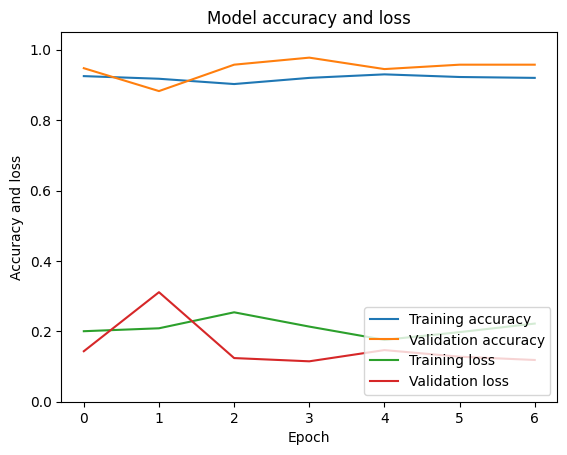

In [217]:
import matplotlib.pyplot as plt

# Plot the training and the validation accuracy and loss in one figure
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model accuracy and loss')
plt.ylabel('Accuracy and loss')
plt.xlabel('Epoch')
plt.ylim(0, 1.05)
plt.legend(['Training accuracy', 'Validation accuracy', 'Training loss', 'Validation loss'], loc='lower right')
plt.show()

In [218]:
# Evaluate the model based on the test data
test_loss, test_acc = model.evaluate(test_set, verbose=2) # verbose=2 to suppress the progress bar
print(f'Test accuracy: {test_acc}')

13/13 - 3s - loss: 0.1148 - accuracy: 0.9775 - 3s/epoch - 236ms/step
Test accuracy: 0.9775000214576721
